In [16]:
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt # data visualization
import ipywidgets as widgets # interactive widgets
from ipywidgets import Box
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
# data loading and descriptive statistics
df = pd.read_csv('SpotifyFeatures.csv')

In [18]:
# update column values
df["genre"].replace({"Children's Music": "Children’s Music"}, inplace=True)
# general category
df["genre"].replace({"Soundtrack": "General","Movie":"General","Anime":"General","Children’s Music":"General","Comedy":"General"}, inplace=True)
# dance
df["genre"].replace({"Hip-Hop": "Dance","R&B":"dance","Dance":"Dance","Rap":"Dance","Pop":"Dance"}, inplace=True)
# folk
df["genre"].replace({"Folk": "Folk","Soul":"Folk","Blues":"Folk","Country":"Folk"}, inplace=True)
# Reggae
df["genre"].replace({"Reggaeton": "Reggae","Ska":"Reggae","Reggae":"Reggae","World":"Reggae"}, inplace=True)
# Alternative
df["genre"].replace({"Indie": "Alternative","Rock":"Alternative","Alternative":"Alternative","Electronic":"Alternative","Jazz":"Alternative"}, inplace=True)
# Reggae
df["genre"].replace({"Classical": "Classical","Opera":"Classical","A Capella":"Classical"}, inplace=True)

In [19]:
# create dummy variables
genre_df=pd.get_dummies(df["genre"]) 
df = pd.concat([df,genre_df],axis=1) 

# create dummy variables - time_signature
time_signature_df=pd.get_dummies(df["time_signature"]) 
df = pd.concat([df,time_signature_df],axis=1) 

# remove old variables
df.drop(['genre','time_signature','0/4','1/4'],axis=1, inplace=True)

In [20]:
# all versions
# Data cleaning and arrangement the data
df['mode'] = np.where(df['mode']=='Major', 1, 0) #change songs' mode (minor/major) to numerical

# change songs duration from milliseconds to seconds
df['duration_ms'] = df['duration_ms'] / 1000
df.rename(columns={'duration_ms': 'duration_s'}, inplace=True) # update column label

# drop variables:
df.drop_duplicates(subset=['track_id'], keep='first',inplace=True)
df.drop(['artist_name','track_name','track_id','key'],axis=1, inplace=True)

In [21]:
# data standardtization
# scale the dataset and make computations more efficient

features = ["duration_s","loudness","tempo","popularity"]
for feature in features:
    mean = df[feature].mean()
    std = df[feature].std()
    df[feature] = (df[feature]-mean)/std 

In [22]:
# feature selection - version +4
df.drop(['duration_s','mode','tempo','valence','5/4','Reggae'],axis=1, inplace=True)

In [23]:
X= df.loc[:,df.columns !="popularity"]
y = df["popularity"]

<AxesSubplot:>

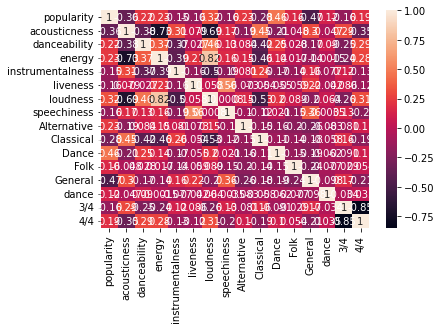

In [24]:
correlation_mat = df.corr()
sns.heatmap(correlation_mat,annot=True)

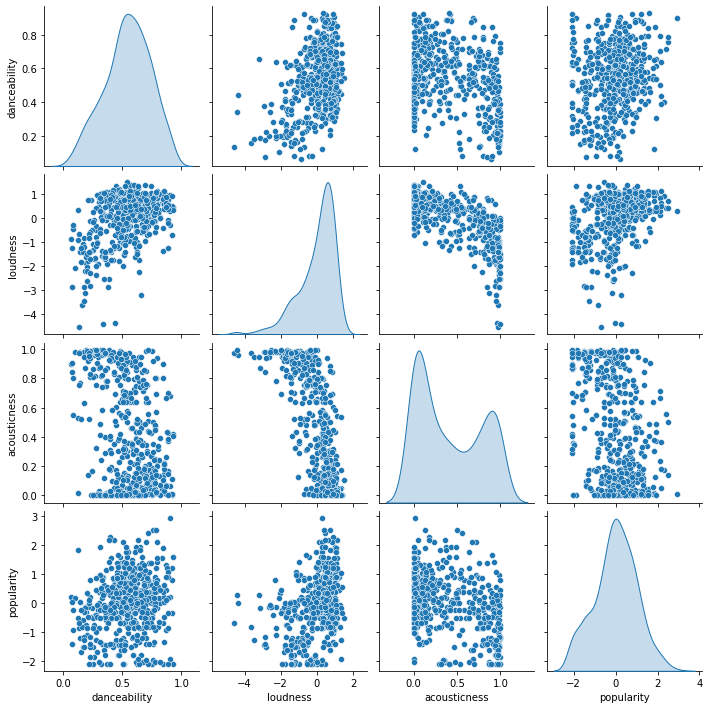

In [25]:

sample = df.sample(500)
sns.pairplot(sample[["danceability","loudness", "acousticness", "popularity"]],diag_kind="kde")


In [26]:
# create a linear regression object
model_regression = linear_model.LinearRegression()

# create a random forest regression object
model_random_forest = RandomForestRegressor()

# create a random forest regression object
model_decision_tree = DecisionTreeRegressor()

In [27]:
# MSE Track
regression_rmse = []
random_forest_rmse = []
decision_tree_rmse = []

In [28]:
# separate the data to training and testing
X_train, X_test, y_train,y_test=train_test_split(X,y,test_size=0.2)
# save as np.array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train) 
y_test = np.array(y_test) 

In [33]:
# Fit the models
model_regression.fit(X_train,y_train)
model_random_forest.fit(X_train,y_train)
model_decision_tree.fit(X_train,y_train)

DecisionTreeRegressor()

In [34]:
y_pred_reg = model_regression.predict(X_test)
y_pred_random_forset = model_random_forest.predict(X_test)
y_pred_decision_tree = model_decision_tree.predict(X_test)

#sns.regplot(y_test[0:100],y_pred_reg[0:100])
mse1 = mean_squared_error(y_test,y_pred_reg)

rmse1 = np.sqrt(mse1)

mse2 = mean_squared_error(y_test,y_pred_random_forset)
# we want smaller rmse
rmse2 = np.sqrt(mse2)


mse3 = mean_squared_error(y_test,y_pred_decision_tree)
# we want smaller rmse
rmse3 = np.sqrt(mse3)


regression_rmse.append(rmse1)
random_forest_rmse.append(rmse2)
decision_tree_rmse.append(rmse3)

In [35]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu,input_shape=[X.shape[1]]),
        layers.Dense(64, activation = tf.nn.relu),
        layers.Dense(1)

    ])
    optimizer = tf.keras.optimizers.RMSprop(.001)
    model.compile(loss="mse",optimizer=optimizer,metrics=['mae','mse']) # examine our model
    return model
model = build_model()

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1024      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________


In [37]:
# train the model
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch % 100==0: print("")
        print('.',end="")

EPOCHS = 10
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(
    X,y, epochs = EPOCHS,validation_split = 0.2, verbose = 0,callbacks = [PrintDot()])


..........

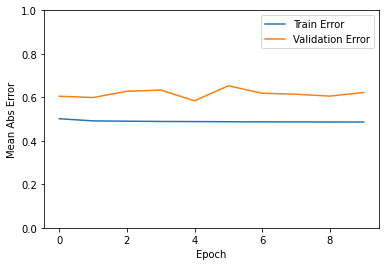

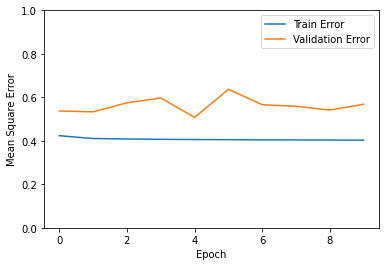

In [38]:

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],label='Train Error')
    plt.plot(hist['epoch'],hist['val_mae'],label='Validation Error')
    plt.legend()
    plt.ylim([0,1])
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label='Validation Error')
    plt.legend()
    plt.ylim([0,1])
plot_history(history)   

1105/1105 [==============================] - 2s 1ms/step


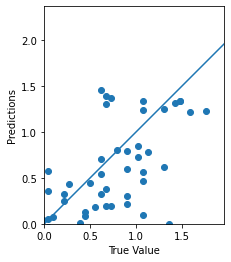

In [39]:
loss, mae, mse = model.evaluate(X_test,y_test,verbose=0)
rmse_DL =  np.sqrt(mse)
dl = [np.nan,np.nan,np.nan,np.nan,np.nan]
dl.append(rmse_DL)

test_predictions = model.predict(X_test).flatten()
plt.scatter(y_test[0:100], test_predictions[0:100])
plt.xlabel("True Value")
plt.ylabel("Predictions")
plt.axis('equal')
plt.axis('Square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])
